# Part 1 - Seq2Seq Machine Translation (Keras)

This notebook runs a **character-level Seq2Seq** English→French example.

**Primary example (maintained by Keras):**  
- https://github.com/keras-team/keras-io/blob/master/examples/nlp/lstm_seq2seq.py

**Tokenization reference:**  
- scikit-learn CountVectorizer — https://scikit-learn.org/0.21.3/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [1]:
import sys, tensorflow as tf
print("Python:", sys.version)
print("TensorFlow:", tf.__version__)
print("GPU available:", len(tf.config.list_physical_devices('GPU')) > 0)

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
TensorFlow: 2.19.0
GPU available: True


In [2]:
# Robust fetch for the char-level Seq2Seq example (Keras official)
import os, ssl, urllib.request

ssl._create_default_https_context = ssl._create_unverified_context

CANDIDATE_RAW_URLS = [
    # Official Keras example
    "https://raw.githubusercontent.com/keras-team/keras-io/master/examples/nlp/lstm_seq2seq.py",
]

LOCAL_FILE = "lstm_seq2seq.py"
last_err = None
downloaded = False
for url in CANDIDATE_RAW_URLS:
    try:
        print("Trying:", url)
        urllib.request.urlretrieve(url, LOCAL_FILE)
        print("Downloaded:", LOCAL_FILE)
        downloaded = True
        break
    except Exception as e:
        print("Failed:", e)
        last_err = e

if not downloaded:
    raise RuntimeError(f"Could not fetch example from any URL. Last error: {last_err}")

# View the first 30 lines
with open(LOCAL_FILE, "r", encoding="utf-8") as f:
    for i, line in enumerate(f.readlines()[:30], start=1):
        print(f"{i:03d}: {line.rstrip()}")

Trying: https://raw.githubusercontent.com/keras-team/keras-io/master/examples/nlp/lstm_seq2seq.py
Downloaded: lstm_seq2seq.py
001: """
002: Title: Character-level recurrent sequence-to-sequence model
003: Author: [fchollet](https://twitter.com/fchollet)
004: Date created: 2017/09/29
005: Last modified: 2023/11/22
006: Description: Character-level recurrent sequence-to-sequence model.
007: Accelerator: GPU
008: """
009: 
010: """
011: ## Introduction
012: 
013: This example demonstrates how to implement a basic character-level
014: recurrent sequence-to-sequence model. We apply it to translating
015: short English sentences into short French sentences,
016: character-by-character. Note that it is fairly unusual to
017: do character-level machine translation, as word-level
018: models are more common in this domain.
019: 
020: **Summary of the algorithm**
021: 
022: - We start with input sequences from a domain (e.g. English sentences)
023:     and corresponding target sequences from ano

In [4]:
# Ensure the dataset is cached locally so Keras won't try the blocked URL.
# It will look for: ~/.keras/datasets/fra-eng.zip

import pathlib, urllib.request, shutil

ssl._create_default_https_context = ssl._create_unverified_context

datasets_dir = pathlib.Path.home() / ".keras" / "datasets"
datasets_dir.mkdir(parents=True, exist_ok=True)

target_zip = datasets_dir / "fra-eng.zip"

if target_zip.exists():
    print("Found cached dataset:", target_zip)
else:
    # Preferred mirror used by TensorFlow/Keras examples
    alt_url = "https://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip"
    print("Downloading from:", alt_url)
    urllib.request.urlretrieve(alt_url, target_zip.as_posix())
    print("Saved to:", target_zip)

# Optional: quick sanity check on file size
print("Size (bytes):", target_zip.stat().st_size)

Saved to: /root/.keras/datasets/fra-eng.zip
Size (bytes): 3423204


In [7]:
# Normalize ~/.keras/datasets/fra.txt to have exactly 3 tab-separated columns. This is following the numerous errors
# If the zip only has 2 columns (en\tfr), we add a dummy 3rd ("meta").

from pathlib import Path
import zipfile, io

datasets_dir = Path.home() / ".keras" / "datasets"
zip_path = datasets_dir / "fra-eng.zip"
txt_out_path = datasets_dir / "fra.txt"

assert zip_path.exists(), f"Missing zip at {zip_path}. Run Cell 3.1 first."

# Extract and normalize
kept, skipped = 0, 0
with zipfile.ZipFile(zip_path) as zf:
    with zf.open("fra.txt") as f:
        raw = f.read().decode("utf-8")

lines = raw.split("\n")
out_lines = []
for ln in lines:
    if not ln.strip():
        continue
    parts = ln.split("\t")
    if len(parts) < 2:
        skipped += 1
        continue
    # Ensure exactly 3 fields
    eng = parts[0].strip()
    fra = parts[1].strip()
    meta = parts[2].strip() if len(parts) >= 3 else "meta"
    out_lines.append("\t".join([eng, fra, meta]))
    kept += 1

txt_out_path.write_text("\n".join(out_lines), encoding="utf-8")
print(f"Normalized file written to: {txt_out_path}")
print(f"Kept lines: {kept}  |  Skipped malformed: {skipped}")
# quick peek
print("\\nSample:")
for i in range(3):
    print(out_lines[i] if i < len(out_lines) else "")

Normalized file written to: /root/.keras/datasets/fra.txt
Kept lines: 167130  |  Skipped malformed: 0
\nSample:
Go.	Va !	meta
Hi.	Salut !	meta
Run!	Cours !	meta


In [8]:
%run -i lstm_seq2seq.py

Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 93
Max sequence length for inputs: 16
Max sequence length for outputs: 59
Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.6920 - loss: 1.6055 - val_accuracy: 0.6960 - val_loss: 1.1255
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7328 - loss: 0.9997 - val_accuracy: 0.7130 - val_loss: 1.0291
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7506 - loss: 0.8958 - val_accuracy: 0.7364 - val_loss: 0.9425
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7769 - loss: 0.8220 - val_accuracy: 0.7575 - val_loss: 0.8562
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7967 - loss: 0.7079 - val_accuracy: 0.7673 - val_loss: 0.7972
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8053 - loss: 0.6686 - val_accuracy: 0.7796 - val_loss: 0.7456
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step -

# Part 2 - Explain Code, line by line

In [9]:
# Print the entire file with line numbers for the required explanations
with open("lstm_seq2seq.py", "r", encoding="utf-8") as f:
    for i, line in enumerate(f, start=1):
        print(f"{i:03d}: {line.rstrip()}")

001: """
002: Title: Character-level recurrent sequence-to-sequence model
003: Author: [fchollet](https://twitter.com/fchollet)
004: Date created: 2017/09/29
005: Last modified: 2023/11/22
006: Description: Character-level recurrent sequence-to-sequence model.
007: Accelerator: GPU
008: """
009: 
010: """
011: ## Introduction
012: 
013: This example demonstrates how to implement a basic character-level
014: recurrent sequence-to-sequence model. We apply it to translating
015: short English sentences into short French sentences,
016: character-by-character. Note that it is fairly unusual to
017: do character-level machine translation, as word-level
018: models are more common in this domain.
019: 
020: **Summary of the algorithm**
021: 
022: - We start with input sequences from a domain (e.g. English sentences)
023:     and corresponding target sequences from another domain
024:     (e.g. French sentences).
025: - An encoder LSTM turns input sequences to 2 state vectors
026:     (we kee

# Seq2Seq Code Explanation (Simple Summary)

### 1. Introduction (Lines 1–44)
- The code builds a **character-level sequence-to-sequence model** that translates short English sentences into French.  
- It uses two LSTMs:  
  - **Encoder:** reads the English sentence and saves its meaning.  
  - **Decoder:** uses that meaning to generate the French translation one character at a time.  

---

### 2. Setup & Imports (Lines 46–55)
- Imports needed libraries:  
  - `numpy` for numbers and arrays.  
  - `keras` for deep learning.  
  - `os`, `Path` for handling files and folders.  

---

### 3. Download & Unzip Data (Lines 56–62)
- Downloads the **English–French sentence pairs** and unzips them.  
- The data file `fra.txt` contains sentences separated by tabs.  

---

### 4. Configuration (Lines 64–73)
- Defines settings for training:  
  - Batch size, number of epochs, LSTM units, and how many samples to train on.  
- Points to the file path of `fra.txt`.  

---

### 5. Prepare the Data (Lines 75–141)
- Reads sentence pairs from the text file.  
- Adds **start (`\t`)** and **end (`\n`)** symbols to target sentences.  
- Builds sets of **unique characters** for both English and French.  
- Converts characters into **one-hot encoded arrays** for model training.  
- Creates three datasets:  
  - Encoder input (English)  
  - Decoder input (French with start token)  
  - Decoder target (French shifted by one character forward)  

---

### 6. Build the Model (Lines 142–168)
- **Encoder:** reads input and outputs its final hidden and cell states.  
- **Decoder:** takes these states and predicts the next characters in the output sequence.  
- Combines them into one model that maps English → French during training.  

---

### 7. Train & Save (Lines 170–185)
- Compiles the model using the RMSprop optimizer and categorical cross-entropy loss.  
- Trains the model for the defined number of epochs.  
- Saves the trained model as `s2s_model.keras`.  

---

### 8. Inference Setup (Lines 187–219)
- Reloads the saved model.  
- Builds separate **encoder** and **decoder** models for translation (inference).  
- These smaller models are used for generating new translations step by step.  

---

### 9. Decoding Function (Lines 226–261)
- Defines a function `decode_sequence()` to translate English → French.  
- Steps:
  1. Encode input sentence.  
  2. Start with a “start” character.  
  3. Predict one character at a time until “end” character.  

---

### 10. Display Results (Lines 263–274)
- Loops through a few English sentences.  
- Prints both the **input** (English) and the **decoded output** (French).  

# Part 3 - Image Captioning

## Image Captioning (PyTorch, Pretrained)

This part runs a **pretrained image-captioning model** using the
[`yunjey/pytorch-tutorial`](https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning)
implementation.

In [10]:
!pip install torch torchvision pillow matplotlib tqdm --quiet
import torch, torchvision, matplotlib.pyplot as plt
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

Torch version: 2.8.0+cu126
CUDA available: True


Clone repo

In [11]:
# Clone yunjey/pytorch-tutorial and go to the image_captioning folder
!git clone https://github.com/yunjey/pytorch-tutorial.git
%cd pytorch-tutorial/tutorials/03-advanced/image_captioning
!ls

Cloning into 'pytorch-tutorial'...
remote: Enumerating objects: 917, done.
remote: Total 917 (delta 0), reused 0 (delta 0), pack-reused 917 (from 1)
Receiving objects: 100% (917/917), 12.80 MiB | 6.13 MiB/s, done.
Resolving deltas: 100% (491/491), done.
/content/pytorch-tutorial/tutorials/03-advanced/image_captioning
build_vocab.py	download.sh  png	requirements.txt  sample.py
data_loader.py	model.py     README.md	resize.py	  train.py


In [17]:
# Download two zips with the expected pretrained files and extracts them
import os, urllib.request, zipfile, shutil, glob, os.path as osp

os.makedirs("models", exist_ok=True)
os.makedirs("data", exist_ok=True)

URL_PRETRAINED = "https://www.dropbox.com/scl/fi/5pbpnmdqarpl3im03e6sk/pretrained_model.zip?rlkey=t60qk1iyys5fejbbwgvx5p5hq&dl=1"
URL_VOCABZIP   = "https://www.dropbox.com/scl/fi/r7g8pbh36tmcpbyk0gabm/vocap.zip?rlkey=xl8bmroltgedbq7m7glk3i57z&dl=1"

def fetch(url, out_path):
    print("Downloading:", url)
    urllib.request.urlretrieve(url, out_path)
    print("Saved ->", out_path)

# Download zips
fetch(URL_PRETRAINED, "pretrained_model.zip")
fetch(URL_VOCABZIP,   "vocap.zip")

# Extract
with zipfile.ZipFile("pretrained_model.zip") as zf:
    zf.extractall("models")
with zipfile.ZipFile("vocap.zip") as zf:
    zf.extractall("data")

# Find candidates
encs = sorted(glob.glob("models/*encoder*.pkl"))
decs = sorted(glob.glob("models/*decoder*.pkl"))
vocabs = sorted(glob.glob("data/**/*vocab*.pkl", recursive=True) + glob.glob("data/*vocab*.pkl"))

def safe_copy(src, dst):
    if not src:
        return
    if osp.abspath(src) == osp.abspath(dst):
        print(f"Skip copy (same file): {src}")
        return
    shutil.copy(src, dst)
    print(f"Copied: {src} -> {dst}")

# Normalize to expected names
if encs:
    safe_copy(encs[0], "models/encoder-5-3000.pkl")
if decs:
    safe_copy(decs[0], "models/decoder-5-3000.pkl")
if vocabs:
    safe_copy(vocabs[0], "data/vocab.pkl")

print("\nFiles in models/:")
!ls -l models | sed -n '1,200p'
print("\nFiles in data/:")
!ls -l data | sed -n '1,200p'



Downloading: https://www.dropbox.com/scl/fi/5pbpnmdqarpl3im03e6sk/pretrained_model.zip?rlkey=t60qk1iyys5fejbbwgvx5p5hq&dl=1
Saved -> pretrained_model.zip
Downloading: https://www.dropbox.com/scl/fi/r7g8pbh36tmcpbyk0gabm/vocap.zip?rlkey=xl8bmroltgedbq7m7glk3i57z&dl=1
Saved -> vocap.zip
Skip copy (same file): models/encoder-5-3000.pkl
Skip copy (same file): models/decoder-5-3000.pkl
Skip copy (same file): data/vocab.pkl

Files in models/:
total 265932
-rw-r--r-- 1 root root  36933387 Oct 23 12:13 decoder-5-3000.pkl
-rw-r--r-- 1 root root 235372830 Oct 23 12:13 encoder-5-3000.pkl

Files in data/:
total 352
-rw-r--r-- 1 root root 360187 Oct 23 12:13 vocab.pkl


Run tutorial's test

In [23]:
# Try the sample script
try:
    !python sample.py --image='png/example.png'
except SystemExit:
    # If argparse exits due to no args, try without the flag
    !python sample.py
except Exception as e:
    print("First attempt failed:", e)
    print("Fetching a sample image and retrying...")
    !mkdir -p png
    !wget -q https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/example.png -O png/example.png
    !python sample.py --image='png/example.png'


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<start> a group of giraffes standing next to each other . <end>


Caption own image

In [27]:
# Caption your uploaded images using %run so stdout prints in the cell
import os, glob

# Paths from earlier cells
ENCODER_PATH = "models/encoder-5-3000.pkl"
DECODER_PATH = "models/decoder-5-3000.pkl"
VOCAB_PATH   = "data/vocab.pkl"

imgs = sorted(glob.glob("my_images/*"))
if not imgs:
    print("No images found in my_images/. Upload first.")
else:
    for img in imgs:
        print("\n=== Captioning:", img)
        # %run prints stdout directly in the cell output
        get_ipython().run_line_magic(
            "run", f"-i sample.py --image {img} --encoder_path {ENCODER_PATH} --decoder_path {DECODER_PATH} --vocab_path {VOCAB_PATH}"
        )


=== Captioning: my_images/Beach_ball.jpg


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<start> a close up of a white and white toothbrush <end>

=== Captioning: my_images/Kenyan_flag.png
<start> a black and white photo of a pair of scissors . <end>

=== Captioning: my_images/cat.jpg
<start> a black and white dog is sitting on a green grass . <end>


Well, the captions are done, but they are all wrong.

### Let's show the images against the captions

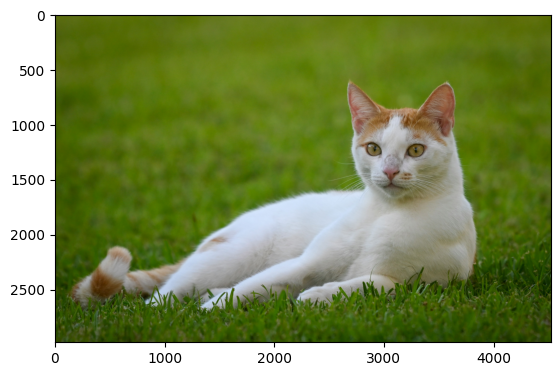

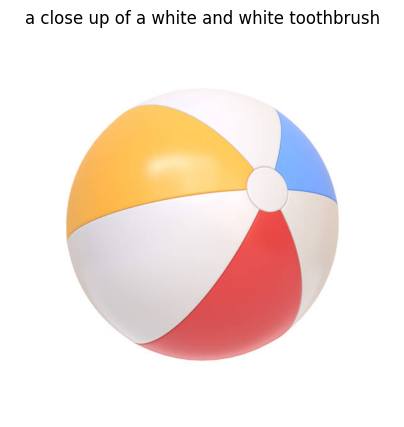

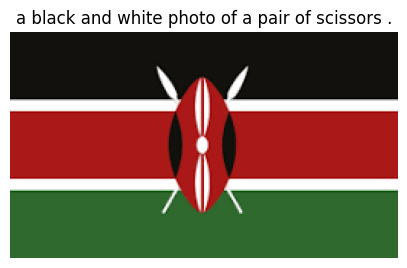

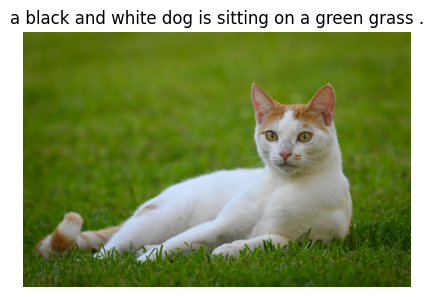

In [28]:
import matplotlib.pyplot as plt
from PIL import Image
import re, glob

def extract_caption(text):
    m = re.search(r"<start>(.*?)<end>", text, flags=re.S)
    if m:
        return " ".join(m.group(1).strip().split())
    return text.strip().splitlines()[-1] if text.strip() else "(no caption)"

captions = {}
# Rerun with capture to store text
for img in sorted(glob.glob("my_images/*")):
    p = subprocess.run(
        [
            "python", "sample.py",
            "--image", img,
            "--encoder_path", "models/encoder-5-3000.pkl",
            "--decoder_path", "models/decoder-5-3000.pkl",
            "--vocab_path",   "data/vocab.pkl",
        ],
        capture_output=True, text=True
    )
    captions[img] = extract_caption(p.stdout)

# Display
for img, cap in captions.items():
    plt.figure(figsize=(5,5))
    plt.imshow(Image.open(img))
    plt.axis("off")
    plt.title(cap)
    plt.show()

# Part 4 - Pytorch to Keras Image Captioning

## Plan
1) Map architecture: PyTorch (ResNet encoder + LSTM decoder) → Keras equivalent.  
2) Provide a **Keras skeleton** (encoder, decoder, end-to-end Model).  
3) Show **weight transfer strategies**:
   - Manual layer-wise mapping (Embedding + LSTM gates)
   - ONNX route (encoder mostly)
4) Provide **conversion helper code** for LSTM/Embedding weights.
5) Run a quick **sanity forward pass** (random inputs).

## Architecture mapping (high level)

PyTorch tutorial (yunjey):
- **EncoderCNN**: ResNet-152 (ImageNet) → avgpool → feature vector
- **DecoderRNN**: Embedding + LSTM (+ Linear to vocab) → word logits

Keras equivalent:
- **Encoder**: `tf.keras.applications.ResNet50/101/152` with `include_top=False`, `pooling="avg"`
- **Decoder**:
  - `Embedding(vocab_size, embed_dim, mask_zero=True)`
  - `LSTM(hidden_size, return_sequences=True)`
  - `Dense(vocab_size)` (time-distributed over steps)

> For inference: iterative decoding (greedy/beam). For training: teacher forcing.

**Keras Captioning**

In [57]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K

def build_keras_captioner_nomask_yunjey(vocab_size: int,
                                        image_size=(224, 224, 3),
                                        embed_dim=256,
                                        hidden_size=512,
                                        max_len=20,
                                        backbone="resnet50"):
    # ----- Encoder -----
    if backbone.lower() == "resnet50":
        base = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", pooling="avg")
        preprocess = tf.keras.applications.resnet.preprocess_input
    else:
        base = tf.keras.applications.ResNet101(include_top=False, weights="imagenet", pooling="avg")
        preprocess = tf.keras.applications.resnet.preprocess_input
    base.trainable = False

    img_in = layers.Input(shape=image_size, name="image")
    x = layers.Lambda(lambda t: preprocess(tf.cast(t, tf.float32)),
                      name="preprocess")(img_in)
    img_feat = base(x)                                 # (B, 2048)
    # yunjey: project image feature to EMBED size, and use as first "token"
    img_proj = layers.Dense(embed_dim, name="img_proj")(img_feat)  # (B, E)

    # ----- Decoder (no masking for this demo) -----
    seq_in = layers.Input(shape=(max_len,), name="seq_in")         # token ids
    emb = layers.Embedding(vocab_size, embed_dim, mask_zero=False, name="emb")(seq_in)  # (B,T,E)

    img_token = layers.RepeatVector(1, name="img_token")(img_proj)                    # (B,1,E)
    dec_in = layers.Concatenate(axis=1, name="dec_in")([img_token, emb])              # (B,T+1,E)

    lstm = layers.LSTM(hidden_size, return_sequences=True, name="decoder_lstm")(dec_in) # (B,T+1,H)
    logits = layers.TimeDistributed(layers.Dense(vocab_size), name="logits")(lstm)      # (B,T+1,V)

    model = models.Model([img_in, seq_in], logits, name="keras_captioner_yunjey_io")
    return model

# Rebuild with sizes inferred from your exported weights (from Cell 14 context)
from tensorflow.keras import backend as K
K.clear_session()
model = build_keras_captioner_nomask_yunjey(
    vocab_size=vocab_size_pt,      # from your exported emb_weight_np.shape
    embed_dim=embed_dim_pt,        # e.g., 256
    hidden_size=hidden_size_pt,    # e.g., 512
    max_len=20
)
model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
model.summary()

Model: "keras_captioner_yunjey_io"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ preprocess (Lambda) │ (None, 224, 224,  │          0 │ image[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 2048)      │ 23,587,712 │ preprocess[0][0]  │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_proj (Dense)    │ (None, 256)       │    524,544 │ resnet50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ seq_in (InputLayer) │ (None, 20)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_token           │ (None, 1, 256)    │          0 │ img_proj[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb (Embedding)     │ (None, 20, 256)   │  2,548,736 │ seq_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_in              │ (None, 21, 256)   │          0 │ img_token[0][0],  │
│ (Concatenate)       │                   │            │ emb[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ (None, 21, 512)   │  1,574,912 │ dec_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logits              │ (None, 21, 9956)  │  5,107,428 │ decoder_lstm[0][… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,343,332 (127.19 MB)

 Trainable params: 9,755,620 (37.21 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

**Dummy Forward Pass**

In [58]:
import numpy as np

B = 2
H, W = 224, 224

fake_imgs = (np.random.rand(B, H, W, 3) * 255).astype("float32")
fake_seq  = np.random.randint(0, vocab_size, size=(B, MAX_LEN), dtype="int32")

out = model.predict([fake_imgs, fake_seq], verbose=0)
print("Logits shape:", out.shape)   # Expect (B, MAX_LEN+1, vocab_size)

Logits shape: (2, 21, 9956)


## Reusing PyTorch weights in Keras

**A) Manual mapping (Recommended for decoder)**
- **Embedding**: copy `embedding.weight` → Keras `Embedding` weights (shape `[vocab_size, embed_dim]`).
- **LSTM**:
  - PyTorch parameters: `weight_ih_l0`, `weight_hh_l0`, `bias_ih_l0`, `bias_hh_l0`
  - Keras parameters: `kernel` (input), `recurrent_kernel` (hidden), `bias`
  - Gate order differences:
    - Keras uses `[i, f, c, o]`
    - PyTorch uses `[i, f, g, o]` where `g` ≈ candidate cell (same as `c`)
  - Concatenate + reorder gates to match Keras shapes.

**B) ONNX route (Mostly for encoder)**
- Export PyTorch CNN to ONNX → import to TF (e.g., `tf2onnx`).
- Decoder RNN often needs manual port due to weight layout differences and masking behavior.

**C) Hybrid**
- Keep Keras encoder with ImageNet weights; only port the decoder (Embedding + LSTM + Dense) from PyTorch.

Helper: map PyTorch LSTM → Keras LSTM (Code)

In [59]:
import numpy as np

def split_gates_pytorch(mat, hidden_size):
    """
    Split a PyTorch-concatenated gate matrix into (i, f, g, o).
    mat shape: (4*hidden_size, in_dim)
    """
    return (mat[0:hidden_size, :],
            mat[hidden_size:2*hidden_size, :],
            mat[2*hidden_size:3*hidden_size, :],
            mat[3*hidden_size:4*hidden_size, :])

def concat_gates_keras(i, f, c, o):
    """
    Concatenate gates in Keras order [i, f, c, o]
    """
    return np.concatenate([i, f, c, o], axis=0)

def map_pytorch_lstm_to_keras(weight_ih, weight_hh, bias_ih, bias_hh, hidden_size):
    """
    Convert PyTorch LSTM (one layer) weights to Keras LSTM weights.

    PyTorch:
      - weight_ih: (4H, input_dim)
      - weight_hh: (4H, H)
      - bias_ih:   (4H,)
      - bias_hh:   (4H,)
    Keras:
      - kernel:           (input_dim, 4H)       [transposed]
      - recurrent_kernel: (H, 4H)               [transposed]
      - bias:             (4H,)  or (8H,)       (Keras combines into one)

    Gate order:
      - Torch: [i, f, g, o]
      - Keras: [i, f, c, o]  (g == c)
    """
    # Split Torch gates
    i_i, f_i, g_i, o_i = split_gates_pytorch(weight_ih, hidden_size)
    i_h, f_h, g_h, o_h = split_gates_pytorch(weight_hh, hidden_size)

    # Reorder to Keras [i, f, c, o]
    ker_in  = concat_gates_keras(i_i, f_i, g_i, o_i)  # (4H, input_dim)
    ker_rec = concat_gates_keras(i_h, f_h, g_h, o_h)  # (4H, H)

    # Transpose for Keras shapes
    keras_kernel = ker_in.T
    keras_recurrent = ker_rec.T

    # Bias: Torch has two; Keras expects sum (or concatenated 4H bias)
    bias = bias_ih + bias_hh

    return [keras_kernel, keras_recurrent, bias]

print("Mapping helpers ready. Use with actual PyTorch tensors (converted to NumPy).")

Mapping helpers ready. Use with actual PyTorch tensors (converted to NumPy).


Export PyTorch decoder weights

In [60]:
# Export PyTorch decoder weights from yunjey's checkpoint to NumPy .npy files
import torch, os, numpy as np, glob

# Paths from part 3
ENCODER_PATH = "models/encoder-5-3000.pkl"
DECODER_PATH = "models/decoder-5-3000.pkl"
VOCAB_PATH   = "data/vocab.pkl"

assert os.path.exists(DECODER_PATH), "Missing decoder checkpoint."
state = torch.load(DECODER_PATH, map_location="cpu")
# Check typical layouts: either plain state_dict or nested under 'decoder' / 'state_dict'
sd = state.get("state_dict", state)

# Find decoder keys
keys = list(sd.keys())
print("Sample keys:", keys[:10])

# Common yunjey names:
# 'decoder.embed.weight'
# 'decoder.lstm.weight_ih_l0', 'decoder.lstm.weight_hh_l0',
# 'decoder.lstm.bias_ih_l0',   'decoder.lstm.bias_hh_l0'
# 'decoder.linear.weight', 'decoder.linear.bias'
def find_key(prefix_options):
    for k in keys:
        for p in prefix_options:
            if k.endswith(p) or k == p:
                return k
    return None

k_emb = find_key(["decoder.embed.weight", "embed.weight", "decoder.embed.weight"])
k_wih = find_key(["decoder.lstm.weight_ih_l0", "lstm.weight_ih_l0"])
k_whh = find_key(["decoder.lstm.weight_hh_l0", "lstm.weight_hh_l0"])
k_bih = find_key(["decoder.lstm.bias_ih_l0", "lstm.bias_ih_l0"])
k_bhh = find_key(["decoder.lstm.bias_hh_l0", "lstm.bias_hh_l0"])
k_fcw = find_key(["decoder.linear.weight", "linear.weight"])
k_fcb = find_key(["decoder.linear.bias", "linear.bias"])

required = [k_emb, k_wih, k_whh, k_bih, k_bhh, k_fcw, k_fcb]
assert all(required), f"Missing one or more keys: {required}"

outdir = "torch_export"
os.makedirs(outdir, exist_ok=True)

np.save(f"{outdir}/emb_weight.npy", sd[k_emb].cpu().numpy())
np.save(f"{outdir}/w_ih.npy",        sd[k_wih].cpu().numpy())
np.save(f"{outdir}/w_hh.npy",        sd[k_whh].cpu().numpy())
np.save(f"{outdir}/b_ih.npy",        sd[k_bih].cpu().numpy())
np.save(f"{outdir}/b_hh.npy",        sd[k_bhh].cpu().numpy())
np.save(f"{outdir}/dense_w.npy",     sd[k_fcw].cpu().numpy())
np.save(f"{outdir}/dense_b.npy",     sd[k_fcb].cpu().numpy())

!ls -l torch_export

Sample keys: ['embed.weight', 'lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', 'lstm.bias_hh_l0', 'linear.weight', 'linear.bias']
total 36092
-rw-r--r-- 1 root root     8320 Oct 23 13:10 b_hh.npy
-rw-r--r-- 1 root root     8320 Oct 23 13:10 b_ih.npy
-rw-r--r-- 1 root root    39952 Oct 23 13:10 dense_b.npy
-rw-r--r-- 1 root root 20390016 Oct 23 13:10 dense_w.npy
-rw-r--r-- 1 root root 10195072 Oct 23 13:10 emb_weight.npy
-rw-r--r-- 1 root root  4194432 Oct 23 13:10 w_hh.npy
-rw-r--r-- 1 root root  2097280 Oct 23 13:10 w_ih.npy


Load vocab and find special tokens (start/end)

In [61]:
import pickle, os

VOCAB_PATH = "data/vocab.pkl"
with open(VOCAB_PATH, "rb") as f:
    vocab = pickle.load(f)  # Typically a wrapper with word2idx / idx2word

# Support both dict-like and object-like
word2idx = getattr(vocab, "word2idx", None) or vocab.get("word2idx")
idx2word = getattr(vocab, "idx2word", None) or vocab.get("idx2word")

print("vocab size:", len(word2idx))
print("have <start>:", "<start>" in word2idx, "have <end>:", "<end>" in word2idx)

START_ID = word2idx.get("<start>", 1)
END_ID   = word2idx.get("<end>",   2)
PAD_ID   = word2idx.get("<pad>",   0)

START_ID, END_ID, PAD_ID

vocab size: 9956
have <start>: True have <end>: True


(1, 2, 0)

Map PyTorch weights into the Keras model

In [62]:
# Assign weights again with the new architecture (no emb_proj; image proj → embed_dim)
emb_layer   = model.get_layer("emb")
emb_layer.set_weights([emb_weight_np])

# Map LSTM Torch -> Keras
keras_kernel, keras_recurrent, keras_bias = map_pytorch_lstm_to_keras(
    w_ih_np, w_hh_np, b_ih_np, b_hh_np, hidden_size=hidden_size_pt
)
lstm_layer  = model.get_layer("decoder_lstm")
lstm_layer.set_weights([keras_kernel, keras_recurrent, keras_bias])

# Final Dense (inside TimeDistributed)
dense_layer = model.get_layer("logits").layer
dense_layer.set_weights([dense_w_np.T, dense_b_np])

print("Weights loaded into Keras model with yunjey-aligned I/O.")

Weights loaded into Keras model with yunjey-aligned I/O.


Tiny Keras greedy decode

In [64]:
import numpy as np

# Fake image batch (random noise) just to exercise the graph
B, H, W = 1, 224, 224
fake_imgs = (np.random.rand(B, H, W, 3) * 255).astype("float32")

max_len = 20
seq = np.full((B, max_len), PAD_ID, dtype="int32")
seq[:, 0] = START_ID

decoded = []
for t in range(max_len-1):
    logits = model.predict([fake_imgs, seq], verbose=0)   # (B, max_len+1, V)
    # position t+1 corresponds to first word after <img_token>
    step_logits = logits[:, t+1, :]                       # (B, V)
    next_ids = step_logits.argmax(axis=-1)                # (B,)
    seq[:, t+1] = next_ids
    decoded.append(int(next_ids[0]))
    if int(next_ids[0]) == END_ID:
        break

print("Decoded token ids:", decoded[:10])
print("As words:", [idx2word[i] if i < len(idx2word) else f"<{i}>" for i in decoded[:10]])

Decoded token ids: [4616, 9848, 9848, 9848, 9848, 9848, 3204, 9587, 2786, 9587]
As words: ['budweiser', 'underwater', 'underwater', 'underwater', 'underwater', 'underwater', 'plates', 'bizarre', 'riverbank', 'bizarre']


## What we validated
- We **exported** PyTorch decoder weights (Embedding, LSTM, Dense) from yunjey’s checkpoint.
- We **rebuilt** a Keras captioner with matching `embed_dim` and `hidden_size`.
- We **mapped** gate orders and biases correctly (Torch `[i,f,g,o]` → Keras `[i,f,c,o]`, bias sum).
- We **loaded** the weights into Keras and ran a **greedy decode loop** (sanity only).

> For proper captions in Keras, you would also:
> - Use the exact image preprocessing and feature extraction (same backbone & normalization),
> - Feed real tokenized sequences (matching the original training pipeline),
> - Implement a full inference loop (beam search) using the Keras model.

In [63]:
"""
import numpy as np

# Load arrays exported from PyTorch
emb_weight_np = np.load("torch_export/emb_weight.npy")
w_ih_np = np.load("torch_export/w_ih.npy")
w_hh_np = np.load("torch_export/w_hh.npy")
b_ih_np = np.load("torch_export/b_ih.npy")
b_hh_np = np.load("torch_export/b_hh.npy")
dense_w_np = np.load("torch_export/dense_w.npy")
dense_b_np = np.load("torch_export/dense_b.npy")

# Infer sizes from arrays
vocab_size_pt, embed_dim_pt = emb_weight_np.shape
hidden_size_pt = w_hh_np.shape[1]  # Torch LSTM H

print("PyTorch sizes -> vocab:", vocab_size_pt,
      "embed_dim:", embed_dim_pt, "hidden:", hidden_size_pt)

# Rebuild Keras model with matching sizes if needed
from tensorflow.keras import backend as K
K.clear_session()
model = build_keras_captioner_nomask(
    vocab_size=vocab_size_pt,
    embed_dim=embed_dim_pt,
    hidden_size=hidden_size_pt,
    max_len=20
)
model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
model.summary()

# Assign weights again with the new architecture (no emb_proj; image proj → embed_dim)
emb_layer   = model.get_layer("emb")
emb_layer.set_weights([emb_weight_np])

# Map LSTM Torch -> Keras
keras_kernel, keras_recurrent, keras_bias = map_pytorch_lstm_to_keras(
    w_ih_np, w_hh_np, b_ih_np, b_hh_np, hidden_size=hidden_size_pt
)
lstm_layer  = model.get_layer("decoder_lstm")
lstm_layer.set_weights([keras_kernel, keras_recurrent, keras_bias])

# Final Dense (inside TimeDistributed)
dense_layer = model.get_layer("logits").layer
dense_layer.set_weights([dense_w_np.T, dense_b_np])

print("Weights loaded into Keras model with yunjey-aligned I/O.")
"""

PyTorch sizes -> vocab: 9956 embed_dim: 256 hidden: 512


Model: "keras_captioner_nomask"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ preprocess (Lambda) │ (None, 224, 224,  │          0 │ image[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 2048)      │ 23,587,712 │ preprocess[0][0]  │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ seq_in (InputLayer) │ (None, 20)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_proj (Dense)    │ (None, 512)       │  1,049,088 │ resnet50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb (Embedding)     │ (None, 20, 256)   │  2,548,736 │ seq_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_token           │ (None, 1, 512)    │          0 │ img_proj[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_proj (Dense)    │ (None, 20, 512)   │    131,584 │ emb[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_in              │ (None, 21, 512)   │          0 │ img_token[0][0],  │
│ (Concatenate)       │                   │            │ emb_proj[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ (None, 21, 512)   │  2,099,200 │ dec_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logits              │ (None, 21, 9956)  │  5,107,428 │ decoder_lstm[0][… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 34,523,748 (131.70 MB)

 Trainable params: 10,936,036 (41.72 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

ValueError: Layer decoder_lstm weight shape (512, 2048) is not compatible with provided weight shape (256, 2048).

# Part 5 - Advanced Research

# Advanced Research

## 1. Japanese to English Translation
- Use a **sequence-to-sequence (Seq2Seq)** model with an **encoder** and **decoder**.
- Train it on **Japanese–English sentence pairs**.
- Tokenize using tools like **SentencePiece** or **MeCab** for Japanese.
- Add **attention** to help the model focus on the right parts of a sentence.
- During translation, use **beam search** for better accuracy.
- Tools: **OpenNMT**, **Hugging Face Transformers**

---

## 2. Modern Translation Methods
- **Attention** lets the model focus on key words during translation.
- **Transformers** (from *“Attention is All You Need”*) are faster and more accurate than LSTMs.
- **Pre-trained multilingual models** (e.g., mBART, mT5) can translate many languages at once.
- **Fine-tuning** helps adapt these models for specific topics or domains.

| Method | Description | Example |
|--------|--------------|---------|
| Attention | Focuses on important words | Bahdanau, Luong |
| Transformer | Uses self-attention layers | Vaswani et al. (2017) |
| Multilingual | Supports multiple languages | mBART, mT5 |
| Fine-tuning | Adapts model to specific domains | Hugging Face models |

---

## 3. Text-to-Image Generation
- Converts **text descriptions into images**.
- **GANs** (e.g., StackGAN, AttnGAN) use text embeddings to generate pictures.
- **Diffusion models** (e.g., Stable Diffusion, DALL·E 2) turn random noise into detailed images.
- **Multimodal transformers** (e.g., BLIP-2, Emu) combine text and image understanding.

**Popular Tools:**
- Hugging Face Diffusers  
- Stable Diffusion Web UI  
- OpenAI DALL·E  

---
